# Optimal Flyer Routing

## Problem Description

Data in hand:
* ~2300 potential locations within ~50 miles of St. Paul.
* Each location node has a **very** rough estimate (based on < 30 collected samples, i.e. basically guessing) of bulletin-board probability [P(bb)]
* geodesic distance from a single origin point to all nodes
* travel distances/durations from each of the visited location to several hundred nearby nodes (sourced from Gmaps API)

Parameters/Constraints:
* No location should be visited more than once
* Soft limit of 5hrs of travel time in a day (ignoring return time for simplicity)
    * Trying to maximize the number of visited locations in the time span, while favoring nodes with high P(bb)
* Traversal takes places over multiple days, repeating from the same start point
    * After each reset, visited nodes are removed, each node's P(bb) is updated, and a new optimal path is calculated

Challenges:
* Each new travel distance calculation requires a call to Gmaps API, which is a paid resource
    * Here API can be used a free(ish) alternative, but the travel estimates are worse
* Based on the limited amount of collected data, distance should be weighted more heavily than P(bb), but exacting a ratio is difficult

### TODOs: 

**Functionality**
* Use OSMNX or some other means of road data to use actual routes instead of creating estimates based on random forest predictions.
* Consider forms of node clustering rather than graph truncation to limit problem dimensionality
    * MIP Solvers cannot handle more than ~60-70 nodes in a fully connected graph in a reasonable amount of time
    * Determine how to correct the algorithm's issues with finding subset solutions. If all nodes cannot be used, it will take a considerable amount of time
* Add node indices as node attribute rather than juggling two separate graphs
* Further research the [Adaptive Heuristic](https://arxiv.org/pdf/1906.07754.pdf) to determine if it is worth keeping 

**Presentation**
* ~~Convert collection of orienteering functions into a standalone class~~
* Documentation on all functions
* Markdown cells to explain outputs
* Explain the Orienteering Problem
* Move helper/non-essential functions into python files to reduce notebook clutter
* Remove frozen cells or move to `flyer_mapping.ipynb`


**Project End Goals**

* Create a seamless end-to-end pipeline from data collection to path updates

### Resources

Orienteering Problem:

http://chekuri.cs.illinois.edu/papers/orienteering-journal.pdf

http://chekuri.cs.illinois.edu/papers/orienteering.pdf

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0213777

https://github.com/cwbollinger/OP_simulator/blob/master/orienteering_solver.py

https://link.springer.com/article/10.1057/jors.1984.162

https://dl.acm.org/citation.cfm?id=2700604

https://github.com/mirgee/orienteering_problem_heuristics/blob/master/GRASP_AOP/

Constrained Least-cost Tour:

https://arxiv.org/pdf/1906.07754.pdf

https://patrickohara.github.io/CLT-problem/cltproblem.html#

https://github.com/torressa/cspy

Combinatorial Optimization:

https://en.wikipedia.org/wiki/Combinatorial_optimization

https://www.cvxpy.org/install/index.html

Vehicle Routing Problem:

https://en.wikipedia.org/wiki/Vehicle_routing_problem

https://developers.google.com/optimization/routing/cvrp

Traveling Salesman/General Graph Algorithms:

http://web.stanford.edu/~ashishg/msande111/notes/chapter5

https://www.youtube.com/watch?v=sOTUaT0aABc

https://en.wikipedia.org/wiki/Shortest_path_problem#Road_networks

https://en.wikipedia.org/wiki/K_shortest_path_routing

https://en.wikipedia.org/wiki/List_of_algorithms#Graph_algorithms

Uncategorized:

https://github.com/gboeing/urban-data-science/blob/master/15-Spatial-Cluster-Analysis/cluster-analysis.ipynb

https://github.com/coin-or/pulp

http://www.pyomo.org/related-projects

https://wiki.python.org/moin/PythonForOperationsResearch

https://pysal.readthedocs.io/en/latest/api.html

https://github.com/sacridini/Awesome-Geospatial#python

### Setup & Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import json
import time
import random
import inspect
import hashlib
import difflib
import functools
from pathlib import Path
import urllib.parse as uparse
from collections import Counter
import itertools

import requests
import pickle
from pprint import pprint
from fuzzywuzzy import fuzz
import numba
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.notebook import tqdm, tnrange
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import scipy as sp
import cvxpy as cx

import googlemaps
import geopy
import geopy.distance as geodist
import geopandas as gpd; gpd.options.display_precision = 6
import shapely

import folium
import folium.plugins
from folium.plugins import MarkerCluster,FeatureGroupSubGroup

import plotly
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx

from bing_api import Bing
from here_api import Here
from orienteering import Orienteering
from _config import config

#### Convenience Functions

In [3]:
def lcsubstr(keywords):
    """Find the longest common substring between a list of keywords"""
    skws = sorted(keywords,key=lambda x: len(x))
    substrs = []
    for kw in skws[1:]:
        dsm = difflib.SequenceMatcher(None,skws[0],kw,autojunk=False)
        mtc = dsm.find_longest_match(0,len(dsm.a),0,len(dsm.b))
        substrs.append(dsm.b[:mtc.size])
    return min(substrs, key=lambda x: len(x))

In [4]:
def destring_list(liststr,resep=r',\s*'):
    # 6 digits of precision is accurate to ~11cm, anything further is likely noise
    # https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude
    if not isinstance(liststr,str):
        return np.round(liststr,6)
    return np.round([*map(np.float,re.split(resep,liststr.strip('[( )]')))],6)

In [5]:
def asstr(latlon):
    return f'{latlon[0]},{latlon[1]}'

def coord_strcomp(x1,x2):
    return f'{x1[0]}{x1[1]}' == f'{x2[0]}{x2[1]}'

In [6]:
def n_permcomb(n,r=2,comb=True):
    return np.math.factorial(n)/(np.math.factorial(r if comb else 1)*np.math.factorial(n-r))

In [7]:
def coord_to(coord, to='place_name', df=None, coord2idx=None):
    df=df if df is not None else df_pdfly
    coord2idx = coord2idx if coord2idx is not None else ll_idx
    return df.at[coord2idx[coord],to] if isinstance(coord,tuple) else df.at[int(coord),to]

In [8]:
def partition_groups(iterable, n_groups=None, max_group_size=None):
    assert (n_groups or max_group_size) is not None, 'exactly one of `n_groups` or `max_group_size` must be provided'
    n_groups = n_groups if n_groups is not None else np.ceil(len(iterable)/(max_group_size))
    return np.array_split(iterable, n_groups)

In [9]:
def gpcode(coords):
    """Long runtime when API key is not provided"""
    url_path='https://plus.codes/api?'
    params = {'address':'{},{}'.format(*coords)}
    resp = requests.get(url_path, params)
    return resp.json()

#### Globals

In [10]:
RAD = 42000 # 40000m ≈ 25 miles
METERMILE = 1609.344
SOURCE = config.geo.CENTERW
BUDGET = 5*60*60 # 5 Hours
px.set_mapbox_access_token(config.MAPBOX_TOKEN)

In [10]:
gmaps = googlemaps.Client(key=config.GMAPS_KEY, timeout=10, retry_over_query_limit=False)
here = Here(config.HERE_APPID,config.HERE_APPCODE)

## Data

**High Success**
* Universities (2/2)
* Community/Recreation Centers (3/3)
* Kwik Trip gas stations (4/4)

**Mixed Success**
* Gas stations general (4/11)
* Laundromats (1/4)

**Limited/No Success**
* Speedway gas stations (0/3)* (one location not recorded)

In [11]:
def update_probs(dfvis, dffly, group_on='keyword', ts_ratio=80, nafill_prob=0.1):
    """Updates probabilities in place and returns constructed mappings
    
    Parameters
    ----------
    dfvis : pd.DataFrame 
        source dataframe containing collected flyer information
    dffly : pd.DataFrame 
        dataframe to be updated with the information in `dfvis`
    group_on : str, (default='keword')
        column name in `dfvis` and `dffly` used to aggregate and generalize probability updates
    ts_ratio : integer (0-100), (default=80) 
        token_set_ratio for fuzzy matching place_names to refine probability updates
    nafill_prob : float, (default=0.1)
        probability to populate unvisited locations
        
    Returns
    -------
    tuple(pd.Series, dict) : 
        {term: probability} parings calculated and used to update dataframes  
    """
    # Initial probablity assignment
    dfvis[group_on] = dfvis[group_on].str.lower()
    grpmap = dfvis.groupby(group_on)['n_flyers'].apply(lambda x: (x>0).mean())
    dfvis['prob_bb'] = dfvis[group_on].map(grpmap)
    dffly['prob_bb'] = dffly[group_on].map(grpmap)
    
    # Refined probability assignment
    # find values where text similarity greater that ts_ratio
    smp = np.argwhere(np.stack(dfvis['place_name'].apply(
        lambda x: np.array([fuzz.token_set_ratio(x,y) for y in dfvis['place_name']])).values) > ts_ratio)
    # convert consecutive indices to groups
    smp_grps = np.split(smp[:,1], np.unique(smp[:,0],return_index = True)[1][1:])
    # remove duplicate groups and singlular groups
    ugrps = filter(lambda x: len(x)>1,map(np.array,np.unique([*map(tuple,smp_grps)])))

    pnmap = {} # place_name mapping
    for g in ugrps:
        prob = (dfvis.loc[g,'n_flyers'] > 0).mean()
        dfvis.loc[g,'prob_bb'] = prob
        pnmap[lcsubstr(dfvis.loc[g,'place_name'])] = prob

    for k,v in pnmap.items(): # fuzzy update with place_name mapping
        dffly.loc[(dffly['place_name'].apply(fuzz.token_set_ratio, s2=k) >= ts_ratio),'prob_bb'] = v
    
    dffly['prob_bb'].fillna(nafill_prob,inplace=True) # set default prob for unvisited locations
    
    return grpmap,pnmap

In [12]:
df_pdfly = pd.read_pickle('data/pdflyers_df.pkl')
df_oppos = pd.read_pickle('data/open_pos_df.pkl')
df_visit = pd.read_pickle('data/visited_details_all_df.pkl')

In [13]:
# Some locations have multiple place_ids, but identical physical location, so we'll drop those for our purposes
# As well as having a unique index for cross ref with df_fdist
df_pdfly = df_pdfly.drop_duplicates('global_code').reset_index(drop=True)
# add consistent geodesic distance to CENTERW column
df_pdfly = df_pdfly.assign(distCW=df_pdfly.latlong.apply(lambda x: geodist.geodesic(SOURCE,x).meters))
# Update bulletin board probability using visited dataframe
update_probs(df_visit,df_pdfly,group_on='keyword')

(keyword
 college              1.000000
 community center     1.000000
 gas station          0.470588
 laundry              0.250000
 park                 1.000000
 recreation center    1.000000
 Name: n_flyers, dtype: float64,
 {'Kwik Trip': 1.0, 'Speedway': 0.0, 'Holiday Stationstores': 0.25})

In [14]:
df_pdfly = pd.concat([pd.Series(config.geo.SOURCEDATA).to_frame().T,df_pdfly],sort=False,axis=0).reset_index(drop=True)

In [15]:
ll_idx = {v:k for k,v in df_pdfly['latlong'].apply(tuple).to_dict().items()}
idx_ll = np.array(list(ll_idx.keys()))
idx2prob = df_pdfly['prob_bb'].to_dict()

In [17]:
df_fdist = pd.read_pickle('data/all_dists_df.pkl')#.rename(lambda x: x.split('.')[1 if len(x.split('.')) > 1 else 0],axis=1).iloc[:,2:]
df_fdist_nb = df_fdist[(df_fdist.dest_ll.str[1] < -92.9) & (df_fdist.geodesic_o2d < RAD)]
df_pdflynb = df_fdist_nb.join(df_pdfly,sort=False).reset_index(drop=True)

In [172]:
df_pdflynb.to_pickle('data/pdflynb_df.pkl')

In [16]:
keep_col = ['place_name', 'prob_bb', 'latlong','distCW','travel_m','travel_secs','place_group','keyword','origin']
df_pdflynb = pd.read_pickle('data/pdflynb_df.pkl')

In [240]:
gdf_fly = gpd.GeoDataFrame(df_pdflynb[keep_col].sample(500))
gdf_fly['geometry']=gdf_fly.apply(lambda x: shapely.geometry.Point(x.latlong) ,axis=1) #shapely.geometry.LineString([config.geo.CENTERW,x.latlong])
gdf_fly.drop(['origin','latlong'],1).to_file('data/geospatial/sampnb_pdfly.shp')
G = nx.read_shp('data/geospatial/sampnb_pdfly.shp')
gpd.read_file('data/geospatial/sampnb_pdfly.shp').head()

## Network Pathing

In [72]:
fdists = [here.distance(config.geo.CENTERW, g)['response']['matrixEntry'] for g in partition_groups(df_pdfly.latlong.values, max_group_size=100)]
df_fdist = json_normalize([y for x in fdists for y in x])
df_fdist['dest_ll'] = [y for x in [
    g[i] for g,i in zip(partition_groups(df_pdfly.latlong.values, max_group_size=100), 
                        partition_groups(df_fdist.destinationIndex, max_group_size=100))] for y in x]
df_fdist['origin_ll'] = str(config.geo.CENTERW)
df_fdist['origin_ll'] = df_fdist.origin_ll.apply(destring_list)
df_fdist['geodesic_o2d'] = df_fdist.apply(lambda x: geodist.geodesic(x.origin_ll,x.dest_ll),axis=1)
df_fdist.to_pickle('data/all_dists_df.pkl')

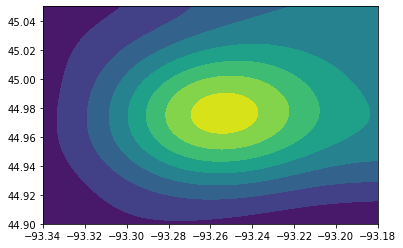

In [24]:
bounds_lat,bounds_lng = (44.9,45.05),(-93.34,-93.18)
hdx,hdy = [*zip(*df_pdfly.latlong)][::-1]
hdx,hdy = np.array(hdx),np.array(hdy)
sns.kdeplot(hdx,hdy,clip=(bounds_lng,bounds_lat),shade=True,cmap='viridis')
high_dens = df_pdfly.latlong[df_pdfly.latlong.str[0].round(2).between(*bounds_lat) & df_pdfly.latlong.str[1].round(2).between(*bounds_lng)]

In [229]:
here=Here(config.HERE_APPID, config.HERE_APPCODE)
high_dens_dists = []
partgrps = partition_groups(high_dens, max_group_size=100)
for o in high_dens.values:
    for grp in partgrps:
        fgrp = grp[~grp.apply(coord_strcomp,x2=o)].values
        high_dens_dists.append((o,fgrp,here.distance(o, fgrp)['response']['matrixEntry']))
pickle.dump(high_dens_dists, open('data/unused_interim/high_density_heredist.pkl','wb'))
hdens_dicts = [{'orig':o, 'dest':dests[d['destinationIndex']], **d['summary']
 } for o, dests, dat in high_dens_dists for d in dat]

In [259]:
df_hddist = pd.DataFrame(hdens_dicts)
hd_o2d = [geodist.geodesic(o,d) for o,d in tqdm(df_hddist[['orig','dest']].values)]
df_hddist['geodesic_o2d'] = hd_o2d
df_hddist.to_pickle('data/hddist_df.pkl')

### Regression Models

In [22]:
df_hddist=pd.read_pickle('data/hddist_df.pkl')
df_fdist_nb = pd.read_pickle('data/all_dists_df.pkl')

In [23]:
df_data = pd.concat([df_hddist,df_fdist_nb],sort=False).reset_index(drop=True)
df_data['olat'] = df_data.origin_ll.str[0]
df_data['olng'] = df_data.origin_ll.str[1]
df_data['dlat'] = df_data.dest_ll.str[0]
df_data['dlng'] = df_data.dest_ll.str[1]

In [24]:
dfd = df_data.drop(columns=['origin_ll','dest_ll','distance','costFactor'])
dfd = dfd.join(dfd.pop('geodesic_o2d'))
X,y = dfd.iloc[:, 1:], dfd.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [25]:
rfr = RandomForestRegressor(100,n_jobs=-1).fit(X_train,y_train)
ypreds = rfr.predict(X_test)
pickle.dump(rfr,open('models/rf_regr.model','wb'))
r2_score(y_test,ypreds)

0.982125485752137

In [27]:
data_xy = df_data[['geodesic_o2d','travelTime']].sort_values('geodesic_o2d')
data_xy = data_xy[data_xy['travelTime'] > 50]
#data_xy = data_xy[data_xy.geodesic_o2d < 22000]

X,y = data_xy.iloc[:,0].values.reshape(-1,1),data_xy.iloc[:,1]
Xsq,ysq = np.sqrt(data_xy.iloc[:,0]).values.reshape(-1,1), np.sqrt(data_xy.iloc[:,1])
Xl,yl = np.log(data_xy.iloc[:,0]).values.reshape(-1,1), np.log(data_xy.iloc[:,1])

X1sq = np.hstack([Xsq, np.ones_like(Xsq)])
X1l = np.hstack([Xl, np.ones_like(Xl)])

lrsq = LinearRegression(fit_intercept=False).fit(X1sq,ysq)
lrl = LinearRegression(fit_intercept=False).fit(X1l,yl)

lrsq.score(X1sq,ysq), lrl.score(X1l,yl) # (0.9526346195819283, 0.9474578241037097)

(0.810954547800737, 0.8303248721223381)

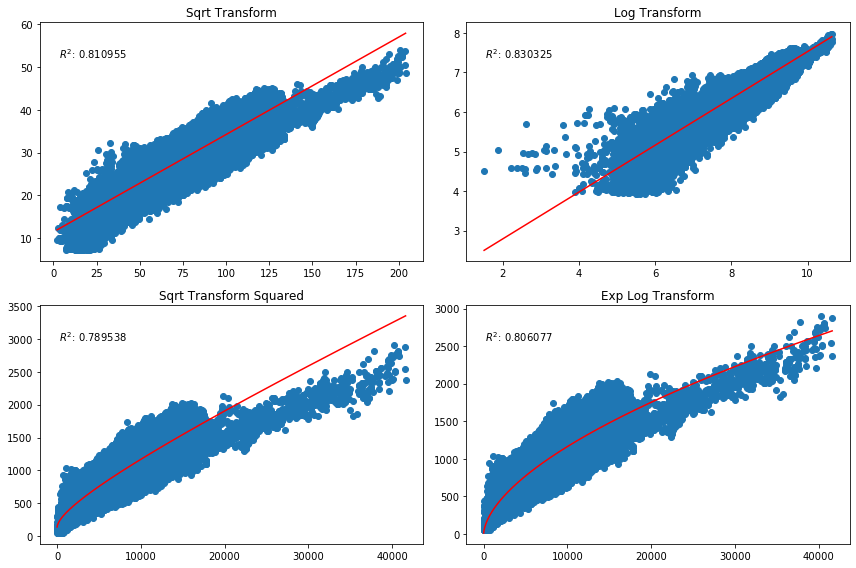

In [31]:
def plot_lr_tsfms(txtpos=(.05,.85)):
    fig, axes = plt.subplots(2,2, figsize=(12,8))
    axes[0,0].scatter(Xsq, ysq)
    axes[0,0].plot(Xsq, X1sq@lrsq.coef_, 'r')
    axes[0,0].annotate(f'$R^2$: {lrsq.score(X1sq,ysq):.6f}',txtpos,xycoords='axes fraction')
    axes[0,0].set_title('Sqrt Transform')

    axes[0,1].scatter(Xl, yl)
    axes[0,1].plot(Xl, X1l@lrl.coef_, 'r')
    axes[0,1].annotate(f'$R^2$: {lrl.score(X1l,yl):.6f}',txtpos,xycoords='axes fraction')
    axes[0,1].set_title('Log Transform');

    axes[1,0].scatter(np.square(Xsq), np.square(ysq))
    axes[1,0].plot(np.square(Xsq), np.square(X1sq@lrsq.coef_), 'r')
    axes[1,0].annotate(f'$R^2$: {r2_score(np.square(ysq),np.square(X1sq@lrsq.coef_)):.6f}',txtpos,xycoords='axes fraction')
    axes[1,0].set_title('Sqrt Transform Squared')

    axes[1,1].scatter(np.exp(Xl), np.exp(yl))
    axes[1,1].plot(np.exp(Xl), np.exp(X1l@lrl.coef_), 'r')
    axes[1,1].annotate(f'$R^2$: {r2_score(np.exp(yl),np.exp(X1l@lrl.coef_)):.6f}',txtpos,xycoords='axes fraction')
    axes[1,1].set_title('Exp Log Transform');
    plt.tight_layout()
plot_lr_tsfms()

In [32]:
'R^2 100 Shortest Dists- Sqrt: {:.6f}, Log: {:.6f}'.format(lrsq.score(X1sq[:100],ysq[:100]),lrl.score(X1l[:100],yl[:100]))

'R^2 100 Shortest Dists- Sqrt: -0.521568, Log: -3.369462'

Although the square root transform leads to an overall better $R^2$, it appears that the log transform better fits smaller distance values. Since we will quite often be calculating within a small radius, we'll move forward with this transform. 

If we wanted to create a better performing model while adding minimal complexity, we could train multiple linear regressors on various segments of the data and use a rule based approach.

### Weighting Functions

In [23]:
def geod_to_travel(xdist,tsfm='log'):
    if tsfm =='log':
        pred= np.exp(np.array([np.log(xdist),1.0])@lrl.coef_)
    else:
        pred = np.square(np.array([np.square(xdist),1.0])@lrsq.coef_)
    return pred

In [24]:
def gtsec_weight(orig,dest):
    return round(geod_to_travel(geodesic_weight(orig,dest)),4)

In [26]:
def gtsec_weightrf(origin,dest,regr=None):
    regr = rfr if regr is None else regr
    xdat = np.array([*origin, *dest, geodesic_weight(origin,dest)],ndmin=2)
    return regr.predict(xdat)[0]

In [18]:
rfr = pickle.load(open('models/rf_regr.model','rb'))

In [18]:
def geodesic_weight(origin, dest, params=None):
    return geodist.geodesic(origin,dest).meters

In [19]:
def form_edges(edges):
    weights = Parallel(n_jobs=-2)(delayed(geodesic_weight)(u,v) for u,v in edges)
    return np.array([[*u,*v,w] for (u,v),w in zip(edges,weights)])

In [20]:
def weight_edges(edges,regr=None):
    regr = rfr if regr is None else regr
    fedges = form_edges(edges)
    preds = np.round(regr.predict(fedges),4)
    return [(u,v,w) for (u,v),w in zip(edges,preds)]

### Plotting Functions

In [21]:
# https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
cm_GrYlOrRd = mpl.colors.LinearSegmentedColormap.from_list('GrYlOrRd',np.vstack((plt.cm.YlGn_r(np.linspace(0.,1,128)),plt.cm.YlOrRd(np.linspace(0,1,128)))))
def color_edges(G, weight='weight', thresh=[.25,.50,.75], colors=['green','yellow','orange','red']):
    if isinstance(thresh[0],float):
        thresh = np.quantile([w for _,_,w in G.edges.data(weight)],thresh)
        nx.get_edge_attributes(G,'weight').values()
    edgecols = [colors[0] if w < thresh[0] else 
                (colors[1] if w < thresh[1] else 
                 (colors[2] if w < thresh[2] else colors[3])) 
                for _,_,w in G.edges.data(weight)]
    return edgecols

In [22]:
def plot_cgraph(G, layout=nx.spring_layout, seed=None, noderelab=None, edgcol_thresh=[.25,.50,.75], edgelist=None, figsize=(8,8)):
    fig,ax = plt.subplots(figsize=figsize)
    pos_sl=layout if isinstance(layout, dict) else layout(G) if seed is None else layout(G,seed=seed)
    
    nodecols = ['green' if u in [0,SOURCE] else 'blue' for u in G.nodes]
    edgecols = color_edges(G, thresh=edgcol_thresh)
    nodelabs = {n:coord_to(n,noderelab) for n in G.nodes} if noderelab is not None else None

    nx.draw_networkx_nodes(G, pos=pos_sl, ax=ax, node_color=nodecols)
    nx.draw_networkx_edges(G, pos=pos_sl, ax=ax, edge_color=edgecols, edgelist=edgelist)
    nx.draw_networkx_labels(G,pos=pos_sl, ax=ax, labels=nodelabs, font_size=10, font_color='k')
    plt.axis('off')
    plt.tight_layout()

In [64]:
def plot_map(G, oppth, chpth=None):
    """Plot possible tour routes and included points
    
    Parameters
    ----------
    G : nx.Graph 
        Complete, untrimmed graph that contains nodes in paths.
    oppth : array-like 
        Nodes in orienteering tour to be plotted.
    chpth : array-like, (default=None)
        Nodes in christofides tour to be plotted. 
        If none, only `oppth` will be displayed.
        
    Returns
    -------
    plotly.figure object
    """
    nodes = [tuple(coord_to(n,'latlong')) for n in G.nodes]
    pldf = pd.DataFrame(nodes,columns=['lat','lon'])
    pldf['latlong'] = nodes
    pldf['prob_bb'] = pldf['latlong'].apply(coord_to,to='prob_bb')#.map(ll_idx).map(idx2prob)
    pldf['place_name'] = pldf['latlong'].apply(coord_to,to='place_name')
    
    
    if isinstance(oppth[0],(np.integer,int)):
        oppth = [idx_ll[t] for t in oppth]
    oppth = np.array(oppth)
    
    if chpth is not None:
        if isinstance(chpth[0],(np.integer,int)):
            chpth = np.array([idx_ll[t] for t in chpth])
    else:
        chpth = np.zeros_like(oppth)

    
    pldf['tour'] = pldf['latlong'].apply(lambda x: 'Both' if x in oppth and x in chpth else ('OP' if x in oppth else ('CH' if x in chpth else 'Excluded')))
    cdm = {k:v for k,v in zip(['OP', 'CH', 'Both', 'Excluded'],px.colors.qualitative.D3[:4])}
    
    
    hovtmpl_nop = ("<b>%{customdata[0]}</b><br>" 
                   "P(bb): %{customdata[3]:%.2f}" 
                   "<extra>%{customdata[4]}</extra>")
    
    hovtmpl = ("<b>%{customdata[0]}</b><br>" 
                "OP,CH : (%{customdata[1]}, %{customdata[2]})<br>" 
                "P(bb): %{customdata[3]:%.2f}" 
                "<extra>%{customdata[4]}</extra>")
    
    for k,v in {'OP':oppth, 'CH':chpth}.items():
        pldf[f'{k}dest'] = pldf['latlong'].apply(lambda x: np.argwhere(v == x)).apply(lambda x: x[0,0] if x.any() else -1)
        
    pfig = go.Figure()

    custcol = ['tour','OPdest','CHdest','prob_bb','place_name']
   
    for k in (['OP','CH'] if chpth.any() else ['OP']):
        tour_df = pldf[pldf[f'{k}dest'] >= 0].sort_values(f'{k}dest').append(pldf.iloc[0])

        cdat = tour_df[custcol]
        vopts = {'name':f'{k}route', 'mode': 'markers+lines+text', 'hovertemplate':hovtmpl}
        
        pfig.add_trace(go.Scattermapbox(
            {'customdata': cdat.values,
             'lat': tour_df['lat'],
             'lon': tour_df['lon'],
             'marker': {'color': cdm[k]},
             'text' : cdat.values[:,1:3],
             'texttemplate' : "(%{text[0]}, %{text[1]})",
             'textposition': 'top right',
             'textfont':{'color':cdm[k]},
             'legendgroup': k,
             'showlegend': True,
             'subplot': 'mapbox',
             'opacity':0.7,
             'type': 'scattermapbox', **vopts}))
        
    for k in ['Both','Excluded']:
        cdat = pldf.loc[pldf['tour'] == k, custcol]
        vopts = {'name':k, 'mode': 'markers', 'hovertemplate':hovtmpl_nop if k=='Excluded' else hovtmpl} 
        pfig.add_trace(go.Scattermapbox(
            {'customdata': cdat.values,
             'lat': pldf.loc[pldf['tour'] == k,'lat'],
             'lon': pldf.loc[pldf['tour'] == k,'lon'],
             'marker': {'color': cdm[k]},
             'legendgroup': k,
             'showlegend': True,
             'subplot': 'mapbox',
             'type': 'scattermapbox', **vopts}))

    mblayout={'margin': {'l':0,'t':0,'b':0,'r':0},
              'mapbox': {'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
                         'center': {'lat': SOURCE[0], 'lon': SOURCE[1]},
                         'accesstoken': config.MAPBOX_TOKEN,'zoom': 8, 'style':'basic'}}
    pfig.update_layout(mblayout)
    return pfig

## Sample Complete Graph

In [24]:
def path_cost(G, path, as_edges=False, dwell_time=0):#5*60
    """Returns: total path cost, original path or edge path"""
    try:
        edge_path = [(p0,p1,G[p0][p1]['weight']+dwell_time) for p0,p1 in nx.utils.pairwise(path)]
    except KeyError as ke:
        print(path)
        raise ke
    pweight = sum(p[2] for p in edge_path)
    return pweight, edge_path if as_edges else path

In [25]:
def qpath_cost(G, path, weight='weight'):
    return sum((G[p0][p1][weight]) for p0,p1 in nx.utils.pairwise(path))
def qpath_prob(G, path, scoreval='prob_bb'):
    return sum(G.nodes[n][scoreval] for n in path)
def qcost_prb_feas(G, path, budget=BUDGET, weight='weight', scoreval='prob_bb'):
    cost = qpath_cost(G, path, weight)
    prob = qpath_prob(G, path, scoreval)
    feas = (cost <= budget)
    return cost, prob, feas

### Trimming Functions

In [115]:
def pretrim_edges(nodes, source=None, max_weight=25*60):
    combs = itertools.combinations(nodes,2) if source is None else itertools.product([source], nodes)
    return [(u,v,w) for u,v,w in weight_edges([*combs]) if w < max_weight] 

def trim_edges(G, max_weight=25*60, weight='weight', **kwargs):
    G.remove_edges_from([(u,v) for u,v,w in G.edges.data(weight) if w > max_weight])
    return G

def trim_degree(G, min_degree=1, **kwargs):
    rm_nodes = [n for n,deg in G.degree if deg < min_degree]
    G.remove_nodes_from(rm_nodes)
    return G

def trim_graph(CG, source=SOURCE, budget=BUDGET, plot=False, noderelab=None, **kwargs):
    mst_CG = nx.tree.minimum_spanning_tree(CG,algorithm=kwargs.get('algorithm','kruskal'))#prim
    tpaths = [nx.shortest_path(mst_CG,source=source,target=n,weight='weight') for n in mst_CG.nodes if n != source]
    for G in [CG,mst_CG]:
        G.remove_nodes_from([path[-1] for cost,path in [path_cost(mst_CG,p, dwell_time=300) for p in tpaths] if cost > budget/2])
    if plot:
        plot_cgraph(mst_CG, figsize=(8,8), noderelab=noderelab)
    return CG

def full_trim(G, source=None, budget=BUDGET, verbose=False, **kwargs):
    if verbose: print(nx.info(G))
    G = trim_graph(G, source=source, budget=budget, **kwargs)
    if verbose: print(nx.info(G))
    G = trim_edges(G, **kwargs)
    if verbose: print(nx.info(G))
    G = trim_degree(G,**kwargs)
    if verbose: print(nx.info(G))
    return G

### Sampling

In [ ]:
keep_col = ['place_name', 'prob_bb', 'latlong','distCW','travel_m','travel_secs','place_group','keyword','origin']

In [27]:
def G_to(G,to='coord_idx',copy=True):
    return nx.relabel_nodes(G,nx.get_node_attributes(G,to),copy=copy)

In [30]:
dfG = df_pdflynb[['latlong','distCW']].sort_values('distCW')#747
gpre = pd.Series([SOURCE],index=[0]).append(dfG['latlong'].map(tuple))
G = nx.complete_graph(gpre, nx.Graph)
G.add_weighted_edges_from(weight_edges(G)) # ~34 sec -> 14 sec parallelized
G.add_nodes_from([(n, {'coord_idx':ll_idx[n], 'coord':n, 'prob_bb':coord_to(n,'prob_bb')}) for n in G.nodes])
pickle.dump(G,open('data/full_weighted.graph','wb'))

In [29]:
G = pickle.load(open('data/full_weighted.graph','rb'))

In [33]:
# TODO: decide if/how subgraphs and node/edge attributes could be used to limit graph copying
print(nx.info(G))
Gt = trim_graph(G.copy(), source=SOURCE, budget=BUDGET, plot=False, algorithm='prim')
Gi = nx.relabel_nodes(G,ll_idx)
Gti = nx.relabel_nodes(Gt,ll_idx); Gti.name = 'complete_graph_index_trimmed'
print(nx.info(Gti))

Name: 
Type: Graph
Number of nodes: 1859
Number of edges: 1727011
Average degree: 1858.0000
Name: complete_graph_index_trimmed
Type: Graph
Number of nodes: 153
Number of edges: 11628
Average degree: 152.0000


## Adaptive Heuristic

https://arxiv.org/pdf/1906.07754.pdf

**Algorithm 1:** Adaptive heuristic for the Constrained Least-cost Cycle Problem

Suurballe and Tarjan’s algorithm at most n = |V(G)|

**input:** 
```
An undirected graph G with edge weights w : E(G) → ℕ and edge costs c : E(G) → ℕ;
the origin s* ∈ V(G); 
lower and upper weight thresholds W₁, W₂ ∈ ℕ.
```

1. Construct a directed, asymmetric graph (G') from the undirected graph G.
    * [build_auxiliary_node_connectivity](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.utils.build_auxiliary_node_connectivity.html?highlight=build%20aux#networkx.algorithms.connectivity.utils.build_auxiliary_node_connectivity)
2. For every pair of vertices u, v ∈ V(G'), compute the least-cost pair of vertex-disjoint paths ∆(u, v) between u and v.
    * [node_disjoint_paths](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.disjoint_paths.node_disjoint_paths.html)
3. From ∆(u, v), construct a simple cycle C. If s* ∈ C, then C is a candidate solution.
    * [simple_cycles](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html?highlight=simple%20cycle)

**output:** The least-cost weight-feasible simple cycle C* from all candidate solutions C.


**Components**

Given an input graph $G$, we construct a graph $G'$ 
by splitting each vertex $v$ of $G$ into two vertices $v_1$ and $v_2$ 
joined by an edge ($v_1$, $v_2$) of length zero. An edge ($v$, $w$)
of G becomes an edge ($v_2$, $w_1$) of $G$

----

In the CLT/CLC problem, we are given an undirected graph $G$ with vertices $V(G)$ and edges $E(G)$.
Edges have a weight function $w : E(G) \rightarrow N$ and a cost function $c : E(G) \rightarrow N$. 

However, Suurballe’s algorithm requires a directed input graph that is asymmetric, that is if $(x, y)$ is an arc in
the graph, then $(y, x)$ is not  in the graph.

We construct a directed, asymmetric graph $G'$ from the undirected graph G as follows. 
* For each vertex $v \in V(G)$, split $v$ into two vertices $v_1$ and $v_2$ and add them to $V(G')$. 
* Add a directed split arc from $v_1$ to $v_2$ in $G'$ with zero cost and zero weight. For every undirected edge $e_{u,v}$ adjacent to $v$ in $G$,
* add a directed arc from $v_2$ to $u_1$ in $G'$ with the same weight and cost as $e_{u,v}$ in $G$. 

The construction requires O(m + n) time and space complexity.

In [30]:
def mxln_mncost(cost_paths):
    mxln = max([len(path) for cost,path in cost_paths])
    opth = min(filter(lambda p: len(p[1]) == mxln, cost_paths),key=lambda c: c[0])
    return opth

In [31]:
def max_prob(G,path_groups):
    mxprob = [max(pgroup,key=lambda p: path_prob(G,p)) for pgroup in path_groups]
    #opth = min(filter(lambda p: len(p[1]) == mxln, cost_paths),key=lambda c: c[0])
    return mxprob

In [32]:
def adaptive_heuristic(CG, source=None, min_weight=None, max_weight=BUDGET):
    A = nx.connectivity.build_auxiliary_node_connectivity(CG)
    R = nx.flow.build_residual_network(A,'capacity')
    flowfn = nx.flow.shortest_augmenting_path # O(n²m) instead of O(nm²) where ,n=nodes,m=edges
    djpaths = [[*nx.node_disjoint_paths(CG,u,v,flow_func=flowfn, auxiliary=A,residual=R)] for u,v in CG.edges]

    #djp_costs = [[path_cost(CG,p, True) for p in d] for d in djpaths]
    #mintoplen = [mxln_mncost(djc)[1] for djc in djp_costs]
    mintoplen = [path_cost(CG, p, True)[1] for p in max_prob(CG,djpaths)]
    
    Gdi = nx.DiGraph()
    Gdi.add_weighted_edges_from([(u,v,w) for wdp in mintoplen for u,v,w in wdp])

    cyc_Gdi = [x for x in tqdm(nx.simple_cycles(Gdi))]
    #cyc_Gdi = [*itertools.dropwhile(lambda c: 0 not in c, nx.simple_cycles(Gdi))]
    scyc_Gdi = [c for c in cyc_Gdi if source in c] # only consider paths that include source
    # Filter out paths that exceed budget
    pcos = [cpath for cpath in [path_cost(Gdi,p) for p in scyc_Gdi] if cpath[0] < max_weight]
    # Maximize visited locations
    opt_paths = sorted(pcos, key=lambda p: len(p[1]), reverse=True)
    opath = max(opt_paths, key=lambda p: path_prob(CG,p))#mxln_mncost(opt_paths)
    
    plot_cgraph(Gdi, nx.shell_layout(Gdi,[Gdi.nodes^opath[1], opath[1]]),noderelab='place_name', edgelist=[*nx.utils.pairwise(opath[1])])
    return Gdi,opt_paths

In [139]:
Gdi,opt_paths = adaptive_heuristic(Gti, 0, max_weight=BUDGET)

## Christofides TSP

In [34]:
# Minor adaptation from https://github.com/BraveDistribution/pytsp/blob/master/pytsp/christofides_tsp.py
def christofides(G, starting_node=0):
    """
    Christofides TSP algorithm
    http://www.dtic.mil/dtic/tr/fulltext/u2/a025602.pdf
    Args:
        G: undirected networkX Graph
        starting_node: of the TSP
    Returns:
        indices of tour nodes given by christofies TSP algorithm
    """
    Gmst = nx.minimum_spanning_tree(G,algorithm='prim')
    graph = nx.to_numpy_array(G)
    mst = nx.to_numpy_array(Gmst)

    odd_degree_nodes = np.nonzero(np.array([d for _,d in Gmst.degree]) % 2 !=0)[0]
    odd_degree_nodes_ix = np.ix_(odd_degree_nodes, odd_degree_nodes)
    nx_graph = nx.from_numpy_array(-1 * graph[odd_degree_nodes_ix])
    matching = nx.max_weight_matching(nx_graph, maxcardinality=True)
    euler_multigraph = nx.MultiGraph(mst)
    for u,v in matching:
        euler_multigraph.add_edge(odd_degree_nodes[u], odd_degree_nodes[v],
                                  weight=graph[odd_degree_nodes[u]][odd_degree_nodes[v]])
    euler_tour = list(nx.eulerian_circuit(euler_multigraph, source=starting_node))
    path = list(itertools.chain.from_iterable(euler_tour))
    return list(dict.fromkeys(path).keys())# drop repeated nodes # +[starting_node])[:-1] , append starting node

In [35]:
def chtpath(G, budget=BUDGET, dwell_time=0, close_path=True):
    nodetype=type([*G.nodes][0])
    cht_tour = np.array(G)[christofides(G)]
    cht_cpath = np.array(path_cost(G,map(nodetype,cht_tour),True,dwell_time)[1])
    budg_mask = cht_cpath[:,2].cumsum(axis=0) <= budget
    lt_budget = cht_cpath[budg_mask]
    
    if close_path:
        while lt_budget[:len(lt_budget),2].sum()+G[lt_budget[len(lt_budget)-1,1]][0]['weight'] > budget:
            lt_budget=lt_budget[:len(lt_budget)-1]

        newitem = [[lt_budget[len(lt_budget)-1,1], 0, G[lt_budget[len(lt_budget)-1,1]][0]['weight']]]
        lt_budget = np.append(lt_budget,newitem,0)

    ult_budget = np.array([int(x[0]) for x in itertools.groupby(lt_budget[:,:2].flatten())])
    
    tour_cost = lt_budget[:,2].sum()
    tour_profit = sum(coord_to(v,'prob_bb') for v in lt_budget[:,1])
    return tour_cost, tour_profit, ult_budget

## Orienteering Problem

If the travel cost allows the selection of half of the customers,
the highest number of non-dominated selections will have to be evaluated by the
algorithm. Moreover, determining the TSP route between the selected customers
becomes more complicated when the number of customers increases. Therefore,
the most difficult OP to solve by any kind of enumeration technique, are those
problems where the selected number of customers is a little more than half the
total number of customers.

In [35]:
from orienteering import Orienteering

In [36]:
ori = Orienteering(Gti,n=64, score_mult=1e4, nodeval='prob_bb')

In [37]:
ori.solve(BUDGET)

Using license file D:\Documents\gurobi.lic
Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Maximum Profit Tour:
0 -> 1036 -> 162 -> 859 -> 131 -> 1101 -> 599 -> 570 -> 1002 -> 1965 -> 74 -> 148 -> 597 -> 1038 -> 1559 -> 1097 -> 1571 -> 287 -> 1078 -> 77 -> 1049 -> 999 -> 976 -> 1497 -> 1738 -> 990 -> 1071 -> 411 -> 1027 -> 1567 -> 734 -> 988 -> 1083 -> 1005 -> 1666 -> 827 -> 186 -> 1026 -> 1013 -> 137 -> 278 -> 205 -> 1025 -> 1087 -> 1116 -> 637 -> 134 -> 1668 -> 447 -> 195 -> 478 -> 826 -> 210 -> 110 -> 1673 -> 1964 -> 1719 -> 1016 -> 310 -> 192 -> 1037 -> 1022 -> 1041 -> 67 -> 0
solve_time: 57.2084 s | tourlen: 65 | cost: 17923.85(17923.85) | profit: 11.4353

In [38]:
ccost,cprofit,cpath = chtpath(Gti)
plot_map(G, ori.tour_,cpath)

In [93]:
np.atleast_2d(weights[:,0])

array([[78,  8, 23, 48, 91, 35, 81, 59, 98, 59, 55, 93, 34, 55, 12, 75,
         9, 98, 31, 58, 79, 49, 36, 28, 37, 67, 69, 44, 54, 70, 28, 63,
        81,  1, 79, 84, 86,  8, 63, 76, 43, 32, 47, 73, 86, 98, 92, 39,
        51, 18, 35, 33, 74, 33, 41, 73, 63, 74, 64, 68, 13, 58, 93, 15]])

In [36]:
def cxsolve(budget, solver=None, verbose=False, timeout=60):
    """Use a cvxpy MIP Solver to approximate a tour that maximizes collected profits

    Valid solvers may include any of ['CBC','GLPK_MI','CPLEX','ECOS_BB','GUROBI']
    provided that the solver is installed.

    For more information on solvers see: 
    https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver

    Parameters
    ----------
    budget : integer 
        Maximum total tour weight. Total cost of returned route will be <= budget
    solver : str, optional (default=None)
        A valid, installed solver name available to cvxpy
    verbose : boolean, (default=False)
        If true, solver will output information as it runs
    timeout : int, (default=60)
        Time (in seconds) before forcibly stoping the solver 
    """

    cost_matrix, score_vector = ori.cost_matrix_, ori.score_vector_

    nnodes=len(score_vector)
    x=cx.Variable((nnodes,nnodes), name='x', boolean=True) # if i -> j is included in tour x_ij is 1 else 0.
    u=cx.Variable(nnodes, name='u') # subtour elimination constraint variables

    cost = cx.trace(cx.matmul(cost_matrix.T,x)) # total cost of the tour
    profit = cx.sum(cx.matmul(x,score_vector))
    nn_ones=np.ones(nnodes)

    # used in place of forloop to clean up constraints
    perm = np.array([*itertools.permutations(np.arange(1,nnodes),2)])
    p0,p1 = perm[:,0], perm[:,1]

    out_con = cx.matmul(x.T,nn_ones) 
    in_con = cx.matmul(x,nn_ones)
    constraints=[cx.sum(x[0,:])==1, # route starts on first node
                 cx.sum(x[:,0])==1, # route ends on first node
                 #cx.sum(x) <= nnodes-1,
                 out_con<=1, # max one outgoing connection
                 in_con<=1, # max one incoming
                 in_con==out_con, # visits = departures
                 cost<=budget, # add the time constraints
                 1 <= u[p0], u[p0] <= nnodes, # subtour elimination
                 u[p0]-u[p1]+1 <= (nnodes-1)*(1-x[p0,p1]), # (Miller-Tucker-Zemlin)
                ] 

    prob=cx.Problem(cx.Maximize(profit),constraints)
    prob.solve(solver=solver, verbose=verbose, TimeLimit=timeout) # TimeLimit may be Gurobi specific

    if prob.status != 'optimal':
        raise cx.SolverError('No feasible solution found, increase budget allotment.')

    (x, u), profit = prob.variables(),prob.value

    prob_dict = {'solve_time': prob.solver_stats.solve_time, 'budget': budget, 'cost': cost.value,
                                    'profit': profit/ori.score_mult, 'x': x.value, 'prob' : prob}
    
    return prob_dict

In [37]:
def tour_costs(x):
    """Should not be called directly. Builds and sets tour attributes"""
    # build tour path and tour cost independent from solver.
    cost_matrix, score_vector, nodes = ori.cost_matrix_, ori.score_vector_, ori.nodes#self._get_params('cost_matrix_', 'score_vector_','nodes')

    ag = np.argmax(x,axis=1)
    cyc = np.array(nx.find_cycle(nx.Graph([(i,ag[i]) for i in ag]),source=0))
    tour = np.array(nodes)[[0, *cyc[:,1]]] # Initialize with source node.
    costs = cost_matrix[cyc[:,0],cyc[:,1]]

    #self._set_params(tour_=tour, costs_=costs)
    return tour,costs

In [459]:
ori = Orienteering(Gti,n=60,score_mult=1e4, nodeval='prob_bb')

In [460]:
ori.solve(BUDGET,verbose=True)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 10449 rows, 3660 columns and 35110 nonzeros
Model fingerprint: 0x761d1e1b
Variable types: 60 continuous, 3600 integer (3600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+03, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective -2000.000000
Presolve removed 6906 rows and 2 columns
Presolve time: 0.09s
Presolved: 3543 rows, 3658 columns, 21003 nonzeros
Variable types: 59 continuous, 3599 integer (3599 binary)

Root relaxation: objective -1.066470e+05, 883 iterations, 0.04 seconds

    Nodes    |    

Maximum Profit Tour:
0 -> 1041 -> 67 -> 310 -> 1016 -> 1964 -> 478 -> 1719 -> 110 -> 1673 -> 826 -> 1026 -> 186 -> 599 -> 570 -> 1101 -> 205 -> 1116 -> 637 -> 134 -> 278 -> 137 -> 1013 -> 1668 -> 195 -> 447 -> 74 -> 148 -> 597 -> 1038 -> 1965 -> 1002 -> 1559 -> 1097 -> 1571 -> 287 -> 162 -> 859 -> 131 -> 77 -> 999 -> 1049 -> 1738 -> 1497 -> 976 -> 734 -> 988 -> 1027 -> 411 -> 990 -> 1071 -> 1567 -> 1083 -> 1005 -> 827 -> 1666 -> 1022 -> 192 -> 1037 -> 1036 -> 0
solve_time: 12.0930 s | tourlen: 61 | cost: 17989.31(17989.31) | profit: 10.6647

## Tabu Search

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.343.256&rep=rep1&type=pdf

* The number of nodes to be visited is randomly chosen.
* The total distance from each node to every other node is calculated.
* The ratio of the score of a node to its total distance is found and this ratio correlates with the probability of including that node in the initial tour.
* Using these probabilities and uniform random numbers between 0 and 1, a (variable length) permutation of visited nodes is created. 

In [175]:
def wchoice(G, n=None, close_path=True, scoreval='prob_bb', weight='weight', randomize=False, seed=None):
    rs = np.random.RandomState(seed)
    gnodes = G.nodes
    if n is None:
        n=rs.randint(2,len(gnodes))
    pratio = np.array([G.nodes[u][scoreval]/nx.degree(G,u,weight=weight) for u in gnodes])
    if randomize:
        pratio = rs.uniform(size=len(gnodes)) * pratio
    pratio = pratio/pratio.sum()
    sbnodes = np.array([0,*rs.choice(gnodes,n,replace=False,p=pratio)])
    return np.append(sbnodes,0) if close_path else sbnodes

1. insert the node in the i-th location after the j-th location.
2. add a node, which is not in the tour, to the tour after the j-th location.
3. delete the node in the i-th location from the tour.
4. simultaneously insert a node and delete a node.
5. reverse the order of nodes between two selected positions while keeping the origin and destination unchanged. 

In [150]:
def perturb(gnodes, tour, p=None, opt=None, verbose=False):
    # http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.343.256&rep=rep1&type=pdf
            
    out_tour = np.setdiff1d(gnodes,tour)
    stour = tour[1:-1].copy() # exclude tails
    st_len = len(stour)
    ot_len = len(out_tour)
    # random.randint is [min,max], np.random.randint is [min,max)
    
    i,j = random.randrange(st_len),random.randrange(st_len) 
    while i == j: # prevent no-ops
        i,j = random.randrange(st_len),random.randrange(st_len) #np.random.randint(st_len,size=2)
    
    # p is always assumed to be an np.array. Performance takes a hit if casted to np.array or using sum() 
    if p is not None:
        p = p/p.sum()  #else np.ones(5)/5

    OPT = random.choices(range(5),weights=p)[0] if opt is None else opt #np.random.choice(range(5),p=p)
    
    if out_tour.any():
        oi = random.randrange(ot_len)
    else: # Disable insert and replace if there are no nodes to select from
        OPT = random.choice([0,3,4])
    
    if OPT == 0:
        # delete the node in the i-th location from the tour.
        stour = np.delete(stour,i)
    elif OPT == 1: 
        # add a node, which is not in the tour, to the tour after the j-th location.
        stour = np.insert(stour,j,out_tour[oi]) # Fail Condition: out_tour is empty -> error
    elif OPT == 2:
        # simultaneously insert a node and delete a node.
        # np.put(stour,j,out_tour[oi])
        stour[j] = out_tour[oi] # Fail Condition: out_tour is empty -> error
    elif OPT == 3: 
        # insert the node in the i-th location after the j-th location.
        # stour[[i,j]] = stour[[j,i]]
        stour[i],stour[j] = stour[j],stour[i]# Fail Condition: i==j -> noop
    else: 
        # reverse the order of nodes between two selected positions while keeping the origin and destination unchanged.
        # stour[i:j] = np.flipud(stour[i:j])
        stour[i:j] = stour[i:j][::-1] # Fail Condition: i==j -> noop
    
    if verbose:
        print(['0-delete','1-insert','2-replace','3-swap','4-reverse'][OPT])
    
    return [tour[0],*stour,tour[0]] #np.array([tour[0],*stour,tour[0]])

In [44]:
def nft_param(r_t, cand_feas, nftp):        
    fratio = 1+(r_t/2) if cand_feas else (1+r_t)/2
    nft = nftp*fratio
    return nft

In [47]:
def to_cmat_svec(Gii):
    cost_matrix = nx.to_numpy_array(Gii)
    score_vector = np.array(Gii.nodes(data='prob_bb'))[:,1]
    return cost_matrix, score_vector

In [46]:
def np_pprob(ixpath,score_vector):
    return score_vector[ixpath].sum()

def np_cost(ixpath,cost_matrix):
    #ix = np.array([ixpath[i:i+2] for i in range(len(ixpath)-1)])
    #cost_matrix[ix[:,0],ix[:,1]].sum()
    return np.array([cost_matrix[ixpath[i],ixpath[i+1]] for i in range(len(ixpath)-1)]).sum()

def np_ncpf(ixpath, cost_matrix, score_vector, budget=BUDGET):
    cost = np_cost(ixpath,cost_matrix)
    sco = np_pprob(ixpath,score_vector)
    feas = (cost <= budget)
    return cost,sco,feas

In [45]:
def pen_obj(cand_cpf, feasratio, best_pp, bestf_pp, nftp, kap=2, budget=BUDGET):
    """Penalized objective function for `tabu_search`"""
    #s_k = cand_pp ; #s_all = best_pp ; #s_feas = bestf_pp

    cand_pc,cand_pp,cand_feas = cand_cpf
    fratio = 1+(feasratio/2) if cand_feas else (1+feasratio)/2
    nft = nftp*fratio
    del_d = np.abs(budget-cand_pc)
    reg = ((del_d/nft))**kap
    s_kp = cand_pp - (best_pp-bestf_pp)*reg
    
    #print('cand {:0.5f}, best {:0.4f}, bestf {:0.4f}, del_d {:0.2f}, nft {:0.4f}, reg {:0.4f} obj {:0.4f}'.format(cand_pp,best_pp,bestf_pp,del_d,nft,reg,s_kp),end='\r',flush=True)
    return s_kp

In [48]:
def tabu_search(G, base_path, n_iter=10000, iter_thresh=0.5, warm_init=None, kap=2, budget=BUDGET):
    """
    Pseudo-Tabu Search implementation for solving the orienteering problem.
    ...
    
    Yun-Chia Liang, Kulturel-Konak, S., & Smith, A. E. (n.d.). 
        Meta heuristics for the orienteering problem. 
        Proceedings of the 2002 Congress on Evolutionary Computation. 
        CEC’02 (Cat. No.02TH8600). doi:10.1109/cec.2002.1006265 
    
    Parameters
    ----------
    G : networkx.Graph
        A fully connected index graph with node attributes for score, 
        and edge attributes for weight.
    base_path : array-like
        Initial starting path, usually built with `wchoice` function.
        Must be index encoded representation of the path, i.e. should
        only contain integer values 0-`G.number_of_nodes()`
    n_iter : integer, (default=10000)
        Maximum number of iterations before terminating procedure.
    iter_thresh : float[0-1], (default=0.5)
        Percentage of `n_iter` to complete before applying a 
        weighted choice to the perturb option selection. Setting
        this to 1 will disable this phase and each option will 
        maintain equal representation. 
    warm_init : float[0-1], optional (default=None)
        Percentage of `G.number_of_nodes()` that serves as the
        minimum length of `base_path` to reach before beginning
        iterations. When length of `base_path` is significantly
        smaller than the total number of available nodes, the
        algorithm will often struggle find improved paths.
    kap : int,float (default=2)
        Exponent in objective function that amplifies the behavior
        of constraint violations in relation to the NFT region. 
    budget : int,float (default=18000)
        Budgetary constraint used in the objective function and
        when determining best feasible paths.
        
    Returns
    -------
    tuple(best_path, best_feasible_path)
    
    References
    ----------
    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.343.256&rep=rep1&type=pdf
    """
    nft = budget*0.10
    feasratio=0
    THRESHOLD = iter_thresh*n_iter
    idxobjs = [0,1,2,3,4] # ensure that all options are included at least once
    idx_bcp = np.ones(5)/5 # fallback if objective does not improve
    
    gnodes = np.array(G.nodes)
    n_n = len(gnodes)
    tl_min, tl_max = n_n//2, n_n*2
    max_tabu_len = random.randint(tl_min,tl_max)
    tabu_list,tabu_feas = [],[]
    
    CM, SV = to_cmat_svec(G)
    
    cand_path = best = bestf = base_path
    
    if warm_init is not None:
        ins_p = np.array([0,1,1,1,1])
        while len(cand_path) < n_n*warm_perc: # kickstart initialization
            cand_path = perturb(gnodes,cand_path, p=ins_p)
            best = perturb(gnodes, best, p=ins_p)
            bestf = perturb(gnodes, bestf, p=ins_p)
    
    bestf_feas = np_cost(bestf,CM) <= budget
    
    del_p = np.array([1,0,1,1,1])
    while not bestf_feas:
        bestf = perturb(gnodes, bestf, p=del_p)
        bestf_feas = np_cost(bestf,CM) <= budget
        
    best_pp = np_pprob(best,SV)
    bestf_pp = np_pprob(bestf,SV)
    
    cand_obj = pen_obj(np_ncpf(cand_path,CM,SV), feasratio, best_pp, bestf_pp, nft, kap=kap)
    
    i5 = np.eye(5)
    tqr = tqdm(range(n_iter), postfix={'best':f'{best_pp:0.4f}','bestf':f'{bestf_pp:0.4f}'})
    for i in tqr:
        ntcands = []

        for opt in range(5):
            px = i5[opt] if i < THRESHOLD else idx_bcp
            cand = perturb(gnodes, cand_path, p=px)

            c_cpf = np_ncpf(cand,CM,SV)
            cobj = pen_obj(c_cpf, feasratio, best_pp, bestf_pp, nft, kap=kap)
            
            if cobj >= cand_obj:
                cand_path = cand
                cand_obj = cobj
                idxobjs.append(opt)
            
            if cand not in tabu_list:
                ntcands.append(cand)
                tabu_list.append(cand)
                tabu_feas.append(c_cpf[2])
                
                if (len(tabu_list) > max_tabu_len):
                    del tabu_list[0],tabu_feas[0]
                
        feasratio = np.sum(tabu_feas)/len(tabu_list)
        
        if len(ntcands) > 0:
            bcand_path = max(ntcands,key=lambda x: np_pprob(x,SV))
            bcand_pp,bcand_feas = np_pprob(bcand_path,SV),(np_cost(bcand_path,CM) <= budget)         
            
            if bcand_pp > best_pp:
                best_pp = bcand_pp
                best = bcand_path
                
            if bcand_feas and bcand_pp >= bestf_pp:
                bestf = bcand_path
                bestf_pp = bcand_pp
                cand_path = bestf
        
        if i % 20:
            max_tabu_len = random.randint(tl_min,tl_max)
            
        if i % 100:
            idx_bc = np.bincount(idxobjs, minlength=5)
            idx_bcp = idx_bc/idx_bc.sum()
            tqr.set_postfix(best=f'{best_pp:0.4f}',bestf=f'{bestf_pp:0.4f}', refresh=False)#px = f'{np.round(idx_bcp,4)}'
            
    return best,bestf

In [49]:
Gtii = nx.relabel.convert_node_labels_to_integers(Gti)
minnode = int(BUDGET//nx.average_shortest_path_length(Gtii,weight='weight'))

In [152]:
nnodes=np.random.randint(minnode,Gtii.number_of_nodes())
ipath = wchoice(Gtii,nnodes)
nnodes

71

* When initial starting nodes is low, the objective function can occasionally get stuck in a local min.
* If the starting path is already decent, it is unlikely that this algorithm will find a better path.
* Approx. 50% of total nodes is a good starting point for the initial path.

In [153]:
tpath = tabu_search(Gtii, ipath, n_iter=10000, iter_thresh=0.5, warm_init=0.5, kap=2, verbose=False)
for path in tpath:
    pnds = np.array(Gti.nodes)[path]
    print('prob: {:0.3f}, cost: {:0.2f}, len: {}'.format(qpath_prob(Gti,pnds),qpath_cost(Gti,pnds),len(path)))


prob: 18.885, cost: 21338.12, len: 117
prob: 18.285, cost: 17985.14, len: 114


In [54]:
Gii = nx.relabel.convert_node_labels_to_integers(Gi)

In [154]:
nno=np.random.randint(20,Gii.number_of_nodes())
ibpath = wchoice(Gii,nno)
nno

722

In [157]:
tbpath = tabu_search(Gii, ibpath, n_iter=10000, iter_thresh=.2, warm_init=None, kap=2.5, verbose=False)
for path in tbpath:
    pnds = np.array(Gi.nodes)[path]
    print('prob: {:0.3f}, cost: {:0.2f}, len: {}'.format(qpath_prob(Gi,pnds),qpath_cost(Gi,pnds),len(path)))


prob: 145.171, cost: 1053589.93, len: 724
prob: 15.750, cost: 17818.64, len: 38


In [156]:
ccost,cprofit,cpath = chtpath(Gti)
cpathi=[[*Gti.nodes].index(c) for c in cpath]
ctpath = tabu_search(Gtii, cpathi, n_iter=5000, iter_thresh=0.5, warm_init=None, kap=2, verbose=False)
for path in ctpath:
    pnds = np.array(Gti.nodes)[path]
    print('prob: {:0.3f}, cost: {:0.2f}, len: {}'.format(qpath_prob(Gti,pnds),qpath_cost(Gti,pnds),len(path)))


prob: 19.065, cost: 22344.22, len: 128
prob: 17.815, cost: 17680.71, len: 126


In [71]:
plot_map(G,np.array(Gti.nodes)[tpath[1]],cpath)

## Misc Experiments

In [105]:
from sklearn.cluster import KMeans

In [133]:
km = KMeans()

In [114]:
gtna = np.array(Gt.nodes)

In [147]:
gtp = km.fit_predict(gtna); gtp

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6,
       6, 6, 7, 7, 6, 7, 6, 6, 7, 4, 4, 4, 4, 4, 4, 4, 7, 4, 6, 7, 4, 7,
       4, 4, 1, 7, 1, 5, 1, 7, 1, 3, 4, 3, 3, 1, 1, 3, 1, 5, 1, 5, 4, 3,
       1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 5, 5, 2, 2])

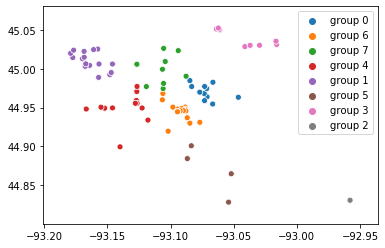

In [148]:
sns.scatterplot(gtna[:,1],gtna[:,0],[f'group {g}' for g in gtp])

In [231]:
CGFt = full_trim(CG.copy(), source=SOURCE, verbose=False, plot=False)

In [47]:
def k_shortest_paths(G, source, target, k, weight='weight'):
    return list(itertools.islice(nx.shortest_simple_paths(G, source, target, weight=weight), k))

In [49]:
k_shortest_paths(CGFt, SOURCE, [*CGFt.nodes][3],10)

[[(44.963963, -93.071135), (44.951412, -93.086758)],
 [(44.963963, -93.071135), (44.951319, -93.090184), (44.951412, -93.086758)],
 [(44.963963, -93.071135), (44.958415, -93.072514), (44.951412, -93.086758)],
 [(44.963963, -93.071135),
  (44.958415, -93.072514),
  (44.951319, -93.090184),
  (44.951412, -93.086758)],
 [(44.963963, -93.071135), (44.943777, -93.096643), (44.951412, -93.086758)],
 [(44.963963, -93.071135), (44.943873, -93.097166), (44.951412, -93.086758)],
 [(44.963963, -93.071135),
  (44.943873, -93.097166),
  (44.943777, -93.096643),
  (44.951412, -93.086758)],
 [(44.963963, -93.071135),
  (44.943777, -93.096643),
  (44.943873, -93.097166),
  (44.951412, -93.086758)],
 [(44.963963, -93.071135),
  (44.951319, -93.090184),
  (44.943777, -93.096643),
  (44.951412, -93.086758)],
 [(44.963963, -93.071135),
  (44.951319, -93.090184),
  (44.943873, -93.097166),
  (44.951412, -93.086758)]]

In [50]:
[*itertools.islice(nx.find_cliques(CGFt),1)]

[[(45.02648, -93.084699),
  (45.013007, -93.169769),
  (45.050653, -93.0615),
  (45.05799, -93.144726),
  (45.056858, -93.148704),
  (45.012986, -93.169723),
  (45.052676, -93.148451),
  (45.078925, -93.121326),
  (45.035511, -93.18732),
  (45.037597, -93.169993),
  (44.943777, -93.096643),
  (44.991754, -93.24371),
  (44.939446, -93.10898),
  (44.951412, -93.086758),
  (44.958415, -93.072514),
  (44.978835, -93.234137),
  (44.971441, -93.105963),
  (44.987709, -93.229924),
  (44.978061, -93.066208),
  (44.943873, -93.097166),
  (44.963963, -93.071135),
  (44.951319, -93.090184),
  (44.899436, -93.140011)]]

In [51]:
[*nx.centrality.current_flow_closeness_centrality(CGFt,weight='weight').items()][:5]

[((44.963963, -93.071135), 467.83893264228175),
 ((44.958415, -93.072514), 472.54545934424317),
 ((44.978061, -93.066208), 477.3744949683672),
 ((44.951412, -93.086758), 465.17073903639914),
 ((44.951319, -93.090184), 465.70298963740936)]

In [52]:
[*nx.centrality.edge_betweenness_centrality(CGFt,weight='weight').items()][:5]

[(((44.963963, -93.071135), (44.958415, -93.072514)), 0.0033333333333333335),
 (((44.963963, -93.071135), (44.978061, -93.066208)), 0.0033333333333333335),
 (((44.963963, -93.071135), (44.951412, -93.086758)), 0.0033333333333333335),
 (((44.963963, -93.071135), (44.951319, -93.090184)), 0.0033333333333333335),
 (((44.963963, -93.071135), (44.971441, -93.105963)), 0.0033333333333333335)]

In [53]:
nx.average_degree_connectivity(CGFt,weight='weight')

{24: 23.802498819881265, 22: 23.999999999999996, 23: 23.99035521002989}

In [54]:
[*nx.neighbor_degree.average_neighbor_degree(CGFt,weight='weight').items()][:5]

[((44.963963, -93.071135), 23.807009370493496),
 ((44.958415, -93.072514), 23.793651019188392),
 ((44.978061, -93.066208), 23.813808873852313),
 ((44.951412, -93.086758), 23.785268952176942),
 ((44.951319, -93.090184), 23.785817141246472)]

In [55]:
nx.voronoi_cells(CGFt,[SOURCE])

{(44.963963, -93.071135): {(44.899436, -93.140011),
  (44.939446, -93.10898),
  (44.943777, -93.096643),
  (44.943873, -93.097166),
  (44.951319, -93.090184),
  (44.951412, -93.086758),
  (44.958415, -93.072514),
  (44.963963, -93.071135),
  (44.971441, -93.105963),
  (44.978061, -93.066208),
  (44.978835, -93.234137),
  (44.987709, -93.229924),
  (44.991754, -93.24371),
  (45.012986, -93.169723),
  (45.013007, -93.169769),
  (45.02648, -93.084699),
  (45.035511, -93.18732),
  (45.037597, -93.169993),
  (45.050653, -93.0615),
  (45.052676, -93.148451),
  (45.056858, -93.148704),
  (45.05799, -93.144726),
  (45.078925, -93.121326),
  (45.08047, -93.13235),
  (45.08084, -93.145307)}}

In [57]:
[*nx.coloring.greedy_color(CGFt).items()][:5]

[((44.963963, -93.071135), 0),
 ((44.958415, -93.072514), 1),
 ((44.978061, -93.066208), 2),
 ((44.951412, -93.086758), 3),
 ((44.951319, -93.090184), 4)]

In [232]:
nx.barycenter(CGFt,weight='weight')

[(44.948103, -93.093947)]

In [234]:
[*nx.clustering(CGFt,weight='weight').items()][:5]

[((44.963963, -93.071135), 0.4584682740878574),
 ((44.965402, -93.150134), 0.5015542612005199),
 ((44.952654, -93.184722), 0.522408432507696),
 ((44.976282, -93.195165), 0.5576986943476605),
 ((44.964322, -93.198052), 0.5293595436435451)]

## OSMNX

In [18]:
import osmnx as ox

In [132]:
here = Here(config.HERE_APPID, config.HERE_APPCODE)

In [238]:
malformed = df_pdfly[df_pdfly.dest_addr.str.split(', ').apply(len) < 3]
malformed.head(3)

place_name                  latlong  \
113                          Lake Maria State Park  [45.315063, -93.951519]   
2                             Otter Lane Book Shop  [45.197761, -93.388925]   
3    Enchantasys Lingerie & More Intimate Boutique  [45.219339, -93.423261]   

                              vicinity             dest_addr     keyword  \
113  11411 Clementa Ave NW, Monticello       ilver Creek, MN        park   
2                 208 E Main St, Anoka  208 E Main St, Anoka  book store   
3                   6111 US-10, Ramsey    6111 US-10, Ramsey  book store   

                                                 types  rating  n_ratings  \
113  [campground, tourist_attraction, lodging, park...     4.6      370.0   
2    [book_store, point_of_interest, store, establi...     0.0        0.0   
3    [book_store, electronics_store, home_goods_sto...     4.0       19.0   

                        place_id place_group    geodesic_m  travel_m  \
113  ChIJVZOc2gWatFIRpusOTu6RuGs   park_camp   1273.033027     80318   
2    ChIJ76xL-IM_s1IRAg42YKWDUSY    academic  36071.796110     11154   
3    ChIJzb-DIaU_s1IRv6LSGd3Cfcg    academic  39671.790927     13541   

     travel_secs                   origin  global_code  price_level  
113         3489  [45.317972, -93.935816]  86Q8828X+29          NaN  
2            921  [45.217293, -93.298682]  86Q85JX6+4C          NaN  
3            830  [45.217293, -93.298682]  86Q86H9G+PM          NaN

In [145]:
mal_rgeo = [gmaps.reverse_geocode(x) for x in malformed.latlong]
json.dump(mal_rgeo, open('data/json/rvgeocode_malform_pdfly.json', 'w'))

In [20]:
mal_rgeo = json.load(open('data/json/rvgeocode_malform_pdfly.json', 'r'))
mal_rvgeo_df = pd.concat([json_normalize(x[0]) for x in mal_rgeo], sort=False)

mal_rvgeo_df = mal_rvgeo_df.drop(mal_rvgeo_df.filter(regex='bounds|viewport|compound').columns,1).rename(lambda x: x.split('.')[-1], axis=1)
mal_rvgeo_df['formatted_address'] = mal_rvgeo_df.formatted_address.str.replace(', USA','')

cities = [x for x in map(lambda x: x.group() if x else None, [re.fullmatch(r'([A-Z][a-z]+ ?)+',x) for x in df_pdfly[df_pdfly.dest_addr.str.split(', ').apply(len) > 2].dest_addr.str.split(', ').str[-2].unique()]) if x]
cities.extend(mal_rvgeo_df.formatted_address.str.split(', ').str[-2].unique())
cities = list(set(cities))

In [21]:
gdf_cities = ox.gdf_from_places([f'{city}, MN, USA' for city in cities])
gdf_cities_proj = ox.project_gdf(gdf_cities)
gdf_cproj_poly = gdf_cities_proj[gdf_cities_proj.geom_type != 'LineString']
gdf_cities

In [22]:
lat_min_S, lat_max_N = df_pdfly.latlong.str[0].min(), df_pdfly.latlong.str[0].max()
lng_min_W, lng_max_E = df_pdfly.latlong.str[1].min(), df_pdfly.latlong.str[1].max()

In [23]:
# (South, West, North, East): min_lat, min_lng, max_lat, max_lng
lat_max_N,lat_min_S,lng_max_E,lng_min_W

(45.539975, 44.673566, -92.452544, -94.241201)

In [29]:
%%time
G1 = ox.graph_from_bbox(lat_max,lat_min,lng_max,lng_min, network_type='drive_service',simplify=False) #4m
G2 = G1.copy() #30s
ox.save_graphml(G1,filename='street_unsimp_bbox_fly.graphml',folder='data/geospatial') #1m45s
G2 = ox.simplify_graph(G2) # 3m
ox.save_graphml(G2,filename='street_simp_bbox_fly.graphml',folder='data/geospatial') #1m45s
G1 = ox.load_graphml('street_unsimp_bbox_fly.graphml',folder='data/geospatial') #?m
G1_proj = ox.project_graph(G1) #4m25
G1_proj = ox.simplify_graph(G1_proj) #3m
ox.save_graphml(G1_proj,filename='street_simpproj_bbox_fly.graphml',folder='data/geospatial') #1m45s

Wall time: 4min 4s



Note that if you want a projected network, it's usually faster for large cities to 
1. say simplify=False, 
2. then project the graph, 
3. then simplify it. 

Projecting a simplified graph with spatial geometries embedded as edge attributes can take a _long_ time in large networks.

In [33]:
G3 = ox.graph_from_bbox(lat_max,lat_min,lng_max,lng_min, network_type='drive',simplify=False) #3m30s
G3_proj = ox.project_graph(G3) #3m45s
G3_proj = ox.simplify_graph(G3_proj) #?
ox.save_graphml(G3_proj,filename='drive_simpproj_bbox_fly.graphml',folder='data/geospatial') #?

Wall time: 3min 35s


In [73]:
%time W10k = ox.graph_from_point(SOURCE,10000,network_type='drive',simplify=False)
#%time W10k = ox.project_graph(W10k)
%time W10k = ox.simplify_graph(W10k)

Wall time: 20.6 s
Wall time: 7.2 s


In [74]:
ox.basic_stats(W10k)

{'n': 15595,
 'm': 42313,
 'k_avg': 5.426482847066367,
 'intersection_count': 13328,
 'streets_per_node_avg': 3.0162231484450146,
 'streets_per_node_counts': {0: 0,
  1: 2267,
  2: 93,
  3: 8456,
  4: 4683,
  5: 91,
  6: 5},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.14536710484129528,
  2: 0.00596344982366143,
  3: 0.5422250721385059,
  4: 0.30028855402372556,
  5: 0.005835203590894517,
  6: 0.0003206155819172812},
 'edge_length_total': 6530951.615000048,
 'edge_length_avg': 154.3485835322489,
 'street_length_total': 3745081.931000025,
 'street_length_avg': 158.70336176794748,
 'street_segments_count': 23598,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.0530701203372628,
 'self_loop_proportion': 0.004230378370713492,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

In [117]:
nbarr = np.array([(d['y'],d['x']) for _,d in sub_W10k.nodes(data=True)])

In [140]:
fig, ax = ox.plot_graph(W10k,fig_height=10, fig_width=10,show=False)
ax.plot(nbarr[:,1],nbarr[:,0],'ro')

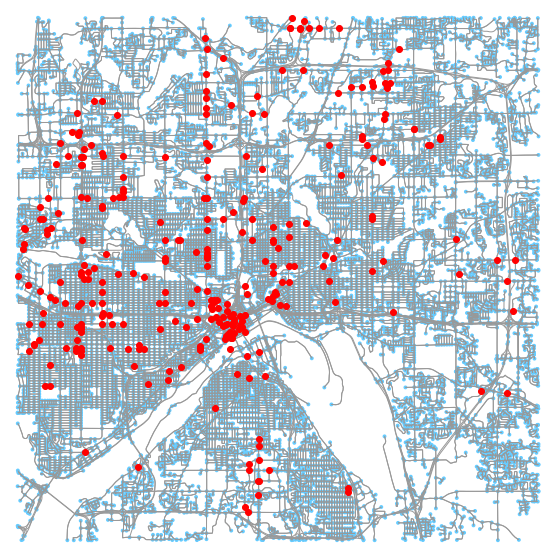

In [141]:
fig

In [129]:
ax.plot(nbarr[:,1],nbarr[:,0],'ro')

In [91]:
locsW10k = df_pdflynb[df_pdflynb.distCW <= 10000]

In [93]:
locsW10k.dest_ll

13      [45.052562, -93.062199]
17      [44.951502, -93.095264]
31      [45.007428, -93.155775]
32      [45.032407, -93.026551]
37      [44.958035, -93.075063]
                 ...           
1692    [44.969713, -93.020687]
1846    [45.046691, -93.106818]
1852    [45.028601, -93.041205]
1853     [44.95913, -93.126742]
1855    [45.001593, -93.077409]
Name: dest_ll, Length: 349, dtype: object

In [96]:
nbnodes = ox.get_nearest_nodes(W10k,locsW10k.dest_ll.str[1],locsW10k.dest_ll.str[0],method='balltree')

In [106]:
sub_W10k = W10k.subgraph(nbnodes).copy()

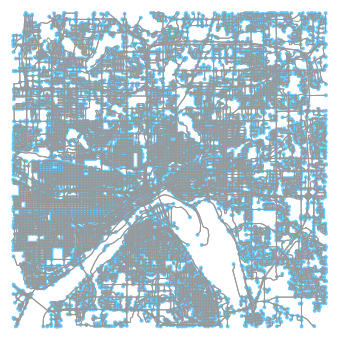

(<Figure size 608.487x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2adf98c6cc0>)

In [108]:
ox.plot_graph(W10k)

In [415]:
nx.draw_networkx_nodes(W10k, nx.layout.planar_layout()

15587

In [68]:
cpoints = np.vstack(df_pdflynb.dest_ll.values)

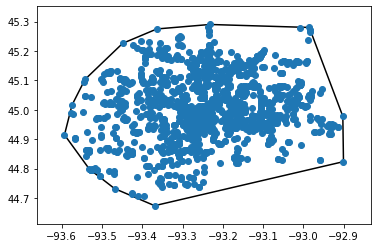

In [69]:
points = cpoints[:,::-1]
hull = sp.spatial.ConvexHull(points)
sp.spatial.convex_hull_plot_2d(hull);

In [70]:
polybb = shapely.geometry.Polygon(points[hull.vertices])

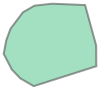

In [404]:
#polybb = ox.round_polygon_coords(polybb,3); polybb

In [72]:
#Gpoly = ox.graph_from_polygon(polybb,'drive',simplify=False,name='metro_points')

In [406]:
Gpoly = ox.project_graph(Gpoly)
Gpoly = ox.simplify_graph(Gpoly)

In [408]:
ox.save_graphml(Gpoly,filename='drive_simpproj_poly_fly.graphml',folder='data/geospatial')

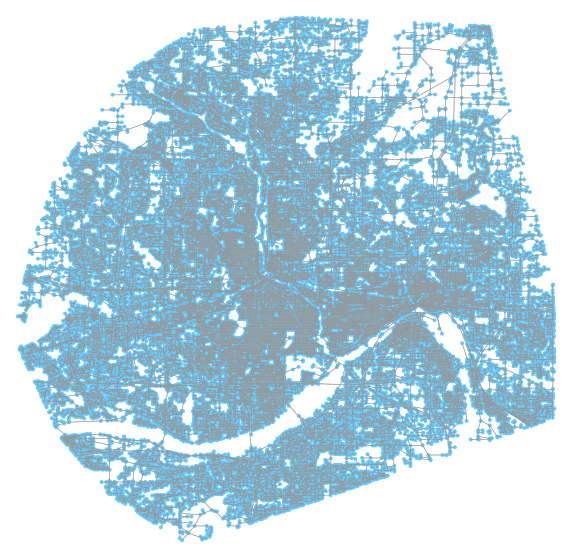

In [413]:
fig,ax = ox.plot_graph(Gpoly,fig_height=10, fig_width=10,edge_linewidth=.6,edge_alpha=.8,use_geom=False)

In [24]:
Gpoly = ox.load_graphml(filename='drive_simpproj_poly_fly.graphml',folder='data/geospatial')

In [318]:
[*itertools.islice(Gpoly.nodes(data=True),1)]

[(2657091855,
  {'y': 4976078.410368689,
   'x': 506367.20645183214,
   'osmid': 2657091855,
   'highway': 'traffic_signals',
   'ref': 'nan',
   'lon': '-92.9193004',
   'lat': '44.93811'})]

In [319]:
np.array(CG.nodes)[0]

array([ 45.152711, -93.16219 ])

In [53]:
coord_to(np.array(CG.nodes)[1],'place_name')

'St. Paul Eastside YMCA'

In [56]:
Gpoly.nodes[ox.get_nearest_node(Gpoly,np.array(CG.nodes)[0])]

{'y': 4992615.313324463,
 'x': 462326.85286295053,
 'osmid': 501191675,
 'highway': 'nan',
 'ref': 'nan',
 'lon': '-93.4787095',
 'lat': '45.0859989'}

In [47]:
Gpoly.nodes(data=True)[ox.get_nearest_node(Gpoly,np.array(CG.nodes)[1])]

{'y': 4992615.313324463,
 'x': 462326.85286295053,
 'osmid': 501191675,
 'highway': 'nan',
 'ref': 'nan',
 'lon': '-93.4787095',
 'lat': '45.0859989'}

In [66]:
nbnodes = ox.get_nearest_nodes(Gpoly,np.array(CG.nodes)[:,0],np.array(CG.nodes)[:,1],method='kdtree')

In [63]:
Gpoly.number_of_nodes()

88589

In [64]:
Gp_sub = Gpoly.subgraph(nbnodes)

In [65]:
Gp_sub.nodes()

NodeView((188063754,))

In [300]:
[*itertools.islice(Gp_sub.nodes(data=True),1)]

[(188565442,
  {'y': 4972946.411169269,
   'x': 505845.41035685764,
   'osmid': 188565442,
   'highway': 'nan',
   'ref': 'nan',
   'lon': '-92.92595',
   'lat': '44.9099201'})]

In [63]:
[Gpoly.nodes(data=True)[n] for n in nnodes]